In [3]:
from pathlib import Path
from kedro.framework.startup import bootstrap_project
from kedro.framework.session import KedroSession

import numpy as np
import pandas as pd
import math
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
import eli5
from eli5.sklearn import PermutationImportance
# from pdpbox import pdp, get_dataset, info_plots
import shap

import optuna

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns
# style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 1) Encontrar la raíz del proyecto (donde está pyproject.toml)
p = Path.cwd().resolve()
project_path = None
for parent in [p] + list(p.parents):
    if (parent / "pyproject.toml").exists():
        project_path = parent
        break

if project_path is None:
    raise RuntimeError(f"No encuentro pyproject.toml desde {Path.cwd()}")

print("Project path:", project_path)

# 2) Bootstrapping Kedro (configura package name, src en sys.path, etc.)
bootstrap_project(project_path)

# 3) Crear sesión y cargar catálogo
with KedroSession.create(project_path=project_path) as session:
    context = session.load_context()

catalog = context.catalog

df_raw = catalog.load("flotation_raw")
df_raw.head()

Project path: C:\Users\Jimena\Documents\yisus\minsur\kedro_projects\mining-quality-kedro


[01/27/26 18:19:04] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=149112;file://C:\Users\Jimena\Documents\yisus\minsur\kedro_projects\.venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=866073;file://C:\Users\Jimena\Documents\yisus\minsur\kedro_projects\.venv\Lib\site-packages\kedro_telemetry\plugin.py#242\242]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/about/telemetry/                                     

[01/27/26 18:19:05] INFO     Loading data from flotation_raw (CSVDataset)...                   ]8;id=792241;file://C:\Users\Jimena\Documents\yisus\minsur\kedro_projects\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=511246;file://C:\Users\Jimena\Documents\yisus\minsur\kedro_projects\.venv\Lib\site-packages\kedro\io\data_catalog.py#1048\1048]8;;\

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [5]:
df_raw.info(),df_raw.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

(None, np.int64(0))

In [7]:
df_raw.describe().T

,count,mean,min,25%,50%,75%,max,std
date,737453,2017-06-16 03:27:22.656549376,2017-03-10 01:00:00,2017-05-04 23:00:00,2017-06-16 15:00:00,2017-07-29 07:00:00,2017-09-09 23:00:00,NaN
% Iron Feed,737453.0,56.294739,42.74,52.67,56.08,59.72,65.78,5.157744
% Silica Feed,737453.0,14.651716,1.31,8.94,13.85,19.6,33.4,6.807439
Starch Flow,737453.0,2869.140569,0.002026,2076.32,3018.43,3727.73,6300.23,1215.203734
Amina Flow,737453.0,488.144697,241.669,431.796,504.393,553.257,739.538,91.230534
Ore Pulp Flow,737453.0,397.578372,376.249,394.264,399.249,402.968,418.641,9.699785
Ore Pulp pH,737453.0,9.767639,8.75334,9.52736,9.7981,10.038,10.8081,0.387007
Ore Pulp Density,737453.0,1.68038,1.51982,1.64731,1.6976,1.72833,1.85325,0.069249
Flotation Column 01 Air Flow,737453.0,280.151856,175.51,250.281,299.344,300.149,373.871,29.621288
Flotation Column 02 Air Flow,737453.0,277.159965,175.156,250.457,296.223,300.69,375.992,30.149357


In [8]:
df_raw= df_raw.drop(df_raw.columns[[0]], axis=1)
train, test = train_test_split(df_raw,test_size=0.2,random_state=42)
train_split,val_split=train_test_split(train,test_size=0.2,random_state=42)
train.shape,test.shape,train_split.shape,val_split.shape

((589962, 23), (147491, 23), (471969, 23), (117993, 23))

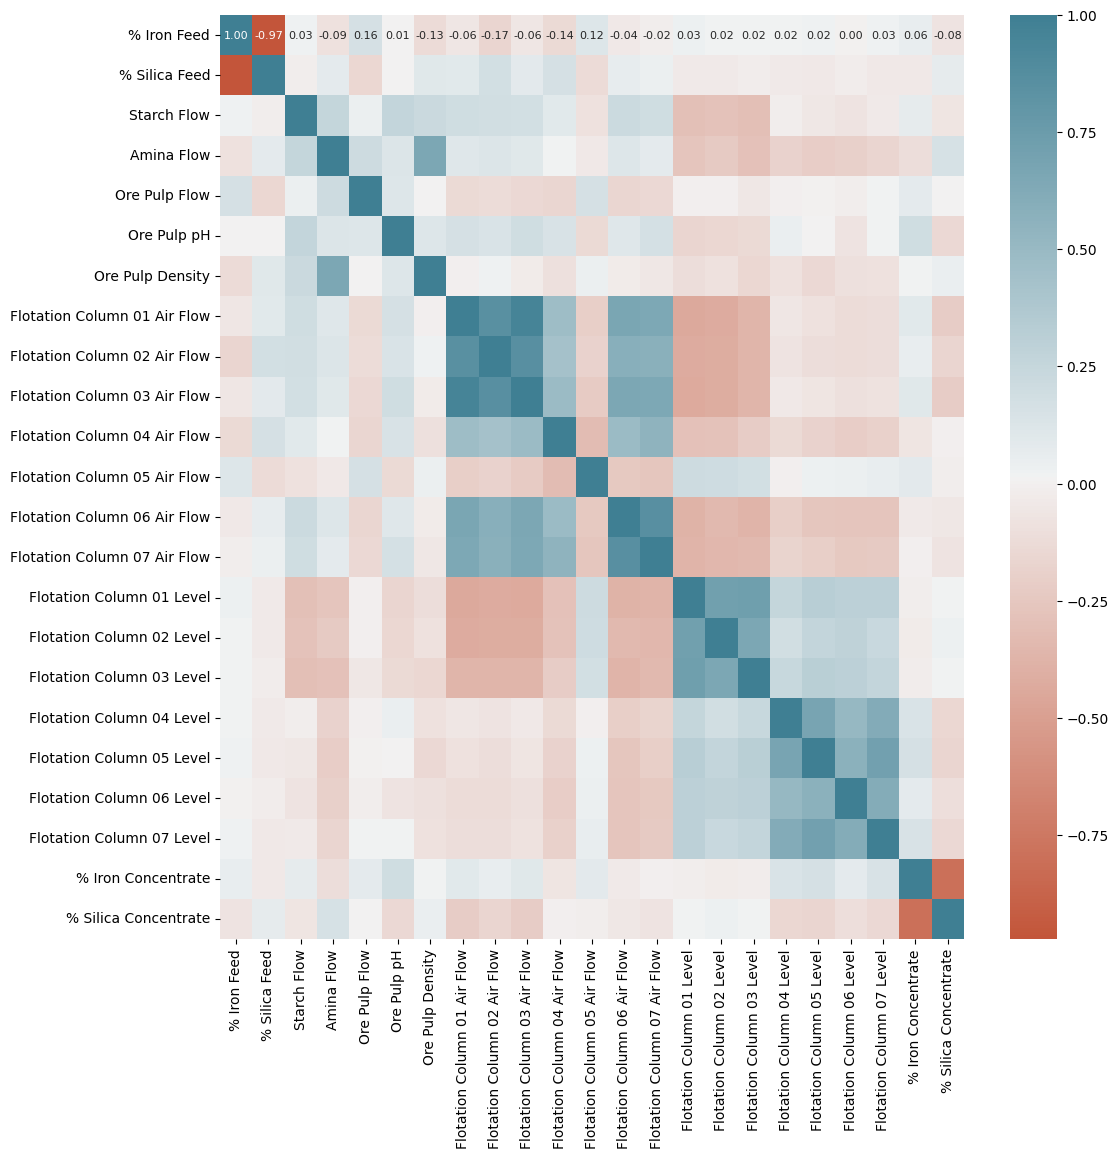

In [9]:
plt.figure(figsize=(12,12))
g = sns.heatmap(train.corr() ,
                fmt='.2f',
                annot=True, 
                annot_kws={'size': 8} ,
                cmap=sns.diverging_palette(20, 220, as_cmap=True)
            )